In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.compartment_transitions import CompartmentTransitions
from recidiviz.calculator.modeling.population_projection.release_transitions import ReleasedTransitions
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
import pandas as pd
from functools import partial
import yaml

In [7]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/LA/LA_prison_habitual_model_inputs.yaml')
# test_sim.simulate_baseline(['prison', 'probation'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 240 results
transitions_data returned 16 results
total_population_data returned 192 results


In [12]:
test_sim.pop_simulations['baseline'].gen_scale_factors_df()

,non-violent,violent
prison,0.525884,0.993861


In [13]:
test_sim.data_dict['transitions_data']

,simulation_tag,compartment_duration,compartment,outflow_to,total_population,crime,crime_type,age,race,date_created
0,LA_HB_364,137.5,prison,probation,1.000,None,non-violent,None,None,2021-01-07 18:14:49.227357+00:00
1,LA_HB_364,378.2,prison,probation,1.000,None,violent,None,None,2021-01-07 18:14:49.227357+00:00
2,LA_HB_364,6.0,release,prison,0.083,None,non-violent,None,None,2021-01-07 18:14:49.227357+00:00
3,LA_HB_364,6.0,release,prison,0.083,None,violent,None,None,2021-01-07 18:14:49.227357+00:00
4,LA_HB_364,960.0,release,release,0.902,None,non-violent,None,None,2021-01-07 18:14:49.227357+00:00
5,LA_HB_364,960.0,release,release,0.902,None,violent,None,None,2021-01-07 18:14:49.227357+00:00
6,LA_HB_364,18.0,release,prison,0.015,None,non-violent,None,None,2021-01-07 18:14:49.227357+00:00
7,LA_HB_364,18.0,release,prison,0.015,None,violent,None,None,2021-01-07 18:14:49.227357+00:00
8,LA_HB_364,36.0,probation,prison,0.093,None,non-violent,None,None,2021-01-07 18:14:49.227357+00:00
9,LA_HB_364,36.0,probation,prison,0.093,None,violent,None,None,2021-01-07 18:14:49.227357+00:00


initialization time:  22.9464430809021
simulation_time:  18.27255892753601
initialization time:  23.7883141040802
simulation_time:  18.425190925598145


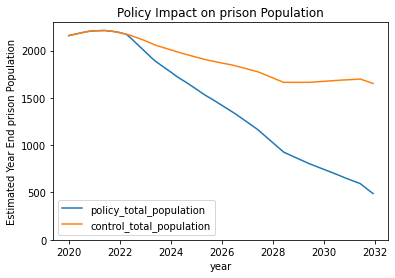

In [10]:
AVERAGE_LOS = {'non-violent': 1.3 * 12, 'violent': 4.8 * 12}

HABITUAL_LOS = {'non-violent': 137.5, 'violent': 378.2}

AFFECTED_FRACTION_A = {'non-violent': 1, 'violent': 0.86}

AFFECTED_FRACTION_B = {'non-violent': 1}


# POLICY A

# Policy Option Methods
def remove_habitual_sentencing(affected_fractions, crime_type, retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_dict={'probation':{
                       'reduction_size': HABITUAL_LOS[crime_type] - AVERAGE_LOS[crime_type],
                       'affected_fraction': affected_fractions[crime_type]
                   }}, 
                   reduction_type = '+',
                   retroactive=retroactive)


policy_list_A = [
    SparkPolicy(policy_fn=remove_habitual_sentencing(AFFECTED_FRACTION_A, crime_type, False),
                spark_compartment='prison',
                sub_population={'crime_type': crime_type},
                apply_retroactive=False)
    for crime_type in AFFECTED_FRACTION_A
]

policy_list_B = [
    SparkPolicy(policy_fn=remove_habitual_sentencing(AFFECTED_FRACTION_B, crime_type, False),
                spark_compartment='prison',
                sub_population={'crime_type': crime_type},
                apply_retroactive=False)
    for crime_type in AFFECTED_FRACTION_B
]
    
test_results = test_sim.simulate_policy(policy_list_B, 'prison')

In [11]:
simulation_tag = 'LA_HB_364_B'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

In [5]:
test_results

(      jail  release        prison
 year                             
 2016   0.0      0.0  0.000000e+00
 2017   0.0      0.0  0.000000e+00
 2018   0.0      0.0  0.000000e+00
 2019   0.0      0.0  0.000000e+00
 2020   0.0      0.0  0.000000e+00
 2021   0.0      0.0  0.000000e+00
 2022   0.0     -0.0  1.315663e+07
 2023   0.0     -0.0  3.163027e+07
 2024   0.0     -0.0  5.424741e+07
 2025   0.0     -0.0  8.023826e+07,
       jail      release       prison
 year                                
 2016   0.0     0.000000     0.000000
 2017   0.0     0.000000     0.000000
 2018   0.0     0.000000     0.000000
 2019   0.0     0.000000     0.000000
 2020   0.0     0.000000     0.000000
 2021   0.0     0.000000     0.000000
 2022   0.0  -409.277499   409.277498
 2023   0.0  -983.956718   983.956715
 2024   0.0 -1687.532192  1687.532187
 2025   0.0 -2496.057356  2496.057350)

In [6]:
test_sim.output_data['life_years']

,jail,release,prison
year,,,
2016,0.0,0.000000,0.000000
2017,0.0,0.000000,0.000000
2018,0.0,0.000000,0.000000
2019,0.0,0.000000,0.000000
2020,0.0,0.000000,0.000000
2021,0.0,0.000000,0.000000
2022,0.0,-409.277499,409.277498
2023,0.0,-983.956718,983.956715
2024,0.0,-1687.532192,1687.532187


In [7]:
test_sim.output_data['cost_avoidance']

,jail,release,prison
year,,,
2016,0.0,0.0,0.000000e+00
2017,0.0,0.0,0.000000e+00
2018,0.0,0.0,0.000000e+00
2019,0.0,0.0,0.000000e+00
2020,0.0,0.0,0.000000e+00
2021,0.0,0.0,0.000000e+00
2022,0.0,-0.0,1.315663e+07
2023,0.0,-0.0,3.163027e+07
2024,0.0,-0.0,5.424741e+07
